In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import shap

from run1.lib.utils import MyUtil

In [2]:
BASE_DIR = Path.cwd()  # Current directory of the running file
ROOT_DIR = BASE_DIR.parent.parent.parent
DATA_DIR = ROOT_DIR / "run1" / "data"
STUDY_DIR = ROOT_DIR / "run1" / "P01_no_af" / "T11_tabPFN"
CURRENT_DIR = BASE_DIR
dt = MyUtil.get_dt()
print(f"CURRENT_DIR: {CURRENT_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"STUDY_DIR: {STUDY_DIR}")
print(f"dt: {dt}")

CURRENT_DIR: c:\Users\admin\Coding\research\weld-ml\run1\P01_no_af\T24_shap_tabPFN
DATA_DIR: c:\Users\admin\Coding\research\weld-ml\run1\data
STUDY_DIR: c:\Users\admin\Coding\research\weld-ml\run1\P01_no_af\T11_tabPFN
dt: 2026-01-30_05-22


In [3]:
OUTDIR = CURRENT_DIR / "S01"
os.makedirs(OUTDIR, exist_ok=True)

In [4]:
filenames = [f for f in os.listdir(OUTDIR)]
print(f"Found {len(filenames)} files:")
print(filenames)


Found 3 files:
['batch_0.pkl', 'batch_1.pkl', 'batch_2.pkl']


In [5]:
shap_values_list = []
for filename in os.listdir(OUTDIR):
    print(f"Loading {filename}...")
    data = MyUtil.load_data(OUTDIR / filename)
    shap_values_list.append(data["shap_values"])

Loading batch_0.pkl...
Loading batch_1.pkl...
Loading batch_2.pkl...


In [6]:
# Combine SHAP values
feature_names = shap_values_list[0].feature_names

# Combine values
combined_shape_values = np.vstack([sv.values for sv in shap_values_list])
combined_shape_values.shape

# Combine base values
combined_base_values = np.concatenate([sv.base_values for sv in shap_values_list])
combined_base_values.shape

# Combine data (feature values)
combined_data = np.vstack([sv.data for sv in shap_values_list])
combined_data.shape

(9, 4)

In [7]:
shap_values = shap.Explanation(
    values=combined_shape_values, 
    base_values=combined_base_values,
    data=combined_data,
    feature_names=shap_values_list[0].feature_names,
)

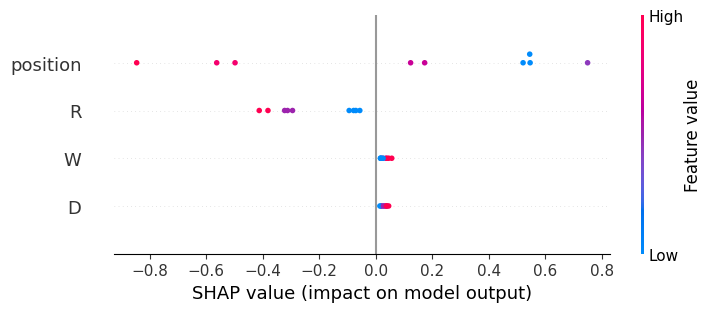

In [8]:
shap.plots.beeswarm(shap_values)

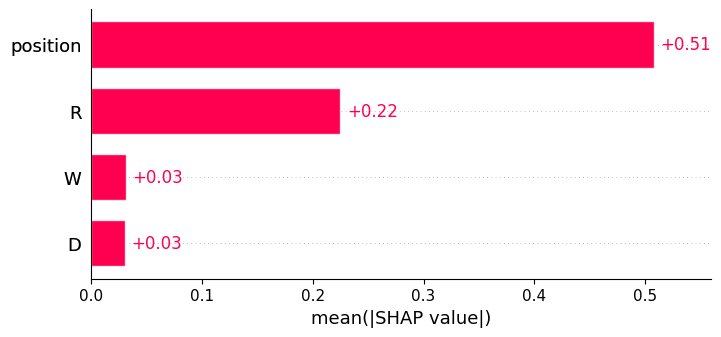

In [9]:
# Plot SHAP bar plot
shap.plots.bar(shap_values)

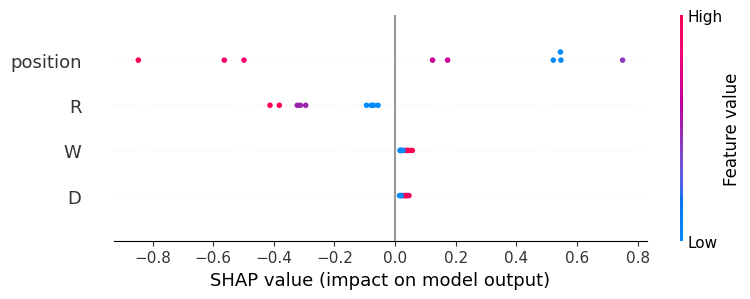

In [10]:
# Plot SHAP summary plot with feature names
shap.summary_plot(shap_values)

In [11]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,position,0.507637
1,R,0.224936
2,W,0.031054
3,D,0.030043


In [12]:
ranking = shap_importance.rename(columns={"col_name": "feature", "feature_importance_vals": "value"})
ranking["measure"] = "SHAP_importance"
ranking["rank"] = np.arange(1, len(ranking) + 1)
ranking

,feature,value,measure,rank
0,position,0.507637,SHAP_importance,1
1,R,0.224936,SHAP_importance,2
2,W,0.031054,SHAP_importance,3
3,D,0.030043,SHAP_importance,4


In [13]:
ranking.to_excel("S02.xlsx", index=False)